# Projeto 2: Classificação binária brest cancer com validação cruzada e dropout

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 11.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import skorch    
from skorch import NeuralNetBinaryClassifier
import torch
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score

In [3]:
torch.__version__, skorch.__version__, sklearn.__version__

('1.13.1+cu116', '0.12.1', '1.2.1')

## Etapa 2: Base de dados

In [4]:
np.random.seed(123)
torch.manual_seed(123)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
previsores = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/entradas_breast.csv')
classe = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/saidas_breast.csv')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


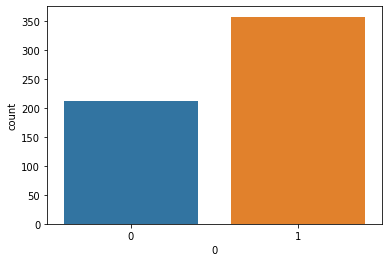

In [7]:
sns.countplot(classe['0']);

In [8]:
classe.shape

(569, 1)

In [9]:
previsores = np.array(previsores, dtype='float32')
classe = np.array(classe, dtype='float32').squeeze(1)

In [10]:
classe.shape

(569,)

In [11]:
type(previsores)

numpy.ndarray

In [12]:
type(classe)

numpy.ndarray

## Etapa 3: Classe para estrutura da rede neural

** ATUALIZAÇÃO DEZ/2021 **: na versão atual do Skorch, os resultados da rede neural devem ser retornados sem ativação, ou seja, sem a camada sigmoide no final. Com isto, a função de custo deve ser `BCEWithLogitsLoss`.

In [13]:
class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO (ver detalhes no texto acima) **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO (ver detalhes no texto acima) **
    return X

## Etapa 4: Skorch

In [14]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

## Etapa 5: Validação cruzada

In [15]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1   107325.7539  0.8224
      2    86254.6316  0.0831
      3    68469.2027  0.0834
      4    53957.7548  0.0818
      5    42087.0202  0.0792
      6    32326.2657  0.0871
      7    24257.5117  0.0873
      8    17518.0687  0.0850
      9    11790.4182  0.0836
     10     6781.5129  0.1021
     11     2218.8336  0.0906
     12      192.7411  0.0796
     13      166.0527  0.0819
     14      142.9379  0.0827
     15      125.7540  0.0828
     16      106.8138  0.0801
     17       91.0727  0.0884
     18       85.3479  0.0835
     19       76.0633  0.0850
     20       69.2977  0.0815
     21       65.5536  0.0865
     22       50.4750  0.0794
     23       49.8331  0.0913
     24       48.9831  0.0814
     25       48.6635  0.0820
     26       46.5278  0.0799
     27       45.3293  0.0819
     28       43.8785  0.0766
     29       43.4529  0.0792
     30       42.8680  0.0831
     31       43.3641  0.0854
     32   

In [16]:
resultados.shape

(10,)

In [17]:
resultados

array([0.84210526, 0.84210526, 0.8245614 , 0.9122807 , 0.84210526,
       0.84210526, 0.87719298, 0.85964912, 0.85964912, 0.78571429])

In [18]:
media = resultados.mean()
media

0.8487468671679199

In [19]:
desvio = resultados.std()
desvio

0.03133358351786874

## Etapa 6: Dropout

In [20]:
class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout0 = nn.Dropout(0.2)
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO **
    return X

In [21]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

In [22]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    76826.3912  0.1014
      2    60939.8435  0.0871
      3    48414.3304  0.0895
      4    36653.4974  0.0869
      5    28375.0033  0.0891
      6    21817.1025  0.0957
      7    16252.4858  0.0946
      8    11266.8600  0.0985
      9     7430.2984  0.0930
     10     4148.7798  0.0871
     11     2851.8537  0.0926
     12     2349.3629  0.0874
     13     2574.3616  0.0891
     14     2280.8981  0.1032
     15     1909.6454  0.0872
     16     1792.1120  0.0890
     17     1636.7897  0.1028
     18     1475.0409  0.0891
     19     1628.6916  0.0911
     20     1758.2288  0.0954
     21     1512.2896  0.0927
     22     1185.2868  0.0923
     23     1009.3950  0.0955
     24     1060.6702  0.0922
     25     1212.9755  0.0931
     26      966.5797  0.0918
     27      882.4842  0.1018
     28      844.1318  0.0949
     29      831.6537  0.0873
     30      682.7002  0.0889
     31      725.7148  0.0885
     32   

In [23]:
media = resultados.mean()
desvio = resultados.std()
media, desvio

(0.6119674185463658, 0.10709046557953394)

In [24]:
resultados

array([0.68421053, 0.54385965, 0.59649123, 0.66666667, 0.66666667,
       0.61403509, 0.43859649, 0.63157895, 0.45614035, 0.82142857])